In [19]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from pymodulon.io import *
from matplotlib_venn import venn3

TRN_df = pd.read_csv('../data/external/TRN.csv', index_col = 0)
ica_data = load_json_model('../data/interim/zmo_raw.json.gz')


In [32]:
df = ica_data.gene_table.fillna(0)


Index(['ZCP4_0012', 'ZCP4_0019', 'ZCP4_0020', 'ZCP4_0028', 'ZCP4_0029',
       'ZCP4_0030', 'ZCP4_0043', 'ZCP4_0049', 'ZCP4_0053', 'ZCP4_0054',
       ...
       'ZCP4_1897', 'ZCP4_1918', 'ZCP4_1919', 'ZCP4_1923', 'ZCP4_1924',
       'ZCP4_1925', 'ZCP4_1930', 'ZCP4_1933', 'ZCP4_1936', 'ZCP4_1937'],
      dtype='object', length=589)

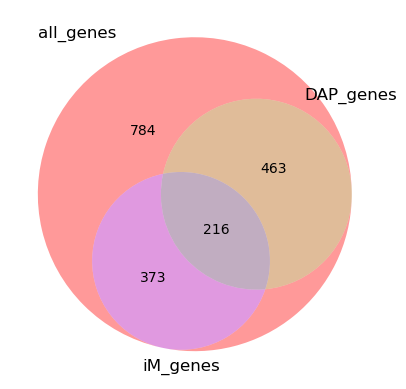

In [34]:
all_genes = set(ica_data.gene_table.index)
DAP_genes = set(TRN_df.gene_id)
iM_genes = set(df[df['iMs'] != 0].index)

venn3([all_genes, DAP_genes, iM_genes], ('all_genes', 'DAP_genes', 'iM_genes'))
plt.savefig('../figures/venn3_overlap.pdf', transparent = True)
plt.show()